In [382]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [383]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, extract, and_, desc

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base= automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [6]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station= Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session= Session(engine)

# Exploratory Climate Analysis

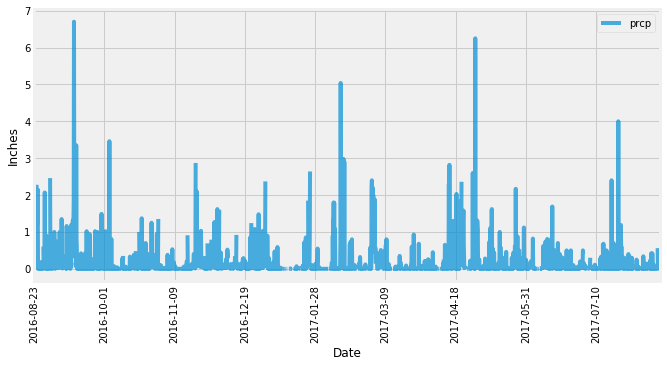

<Figure size 432x288 with 0 Axes>

In [22]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
stmt = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date>= '2016-08-23')

df = pd.read_sql_query(stmt.statement, session.bind)
df.set_index('date', inplace=True)
df.sort_values('date', inplace = True)

df_plot= df.plot(figsize=(10,5), rot=90, alpha=0.7)
df_plot.set_ylabel('Inches')
df_plot.set_xlabel('Date')
plt.show()
plt.tight_layout()

In [32]:
# Query the last date
last_date= session.query(Measurement.date).\
            order_by(Measurement.date.desc()).first()[0]
print(f'Last date {last_date} in the dataset.')

Last date 2017-08-23 in the dataset.


In [45]:
# Calculate the date 1 year ago from the last data point in the database
req_date= dt.date(2017, 8, 23) - dt.timedelta(days=365)

print(req_date)

2016-08-23


In [46]:
# Summary statistics for the precipitation data.
print(df.describe())

              prcp
count  2021.000000
mean      0.177279
std       0.461190
min       0.000000
25%       0.000000
50%       0.020000
75%       0.130000
max       6.700000


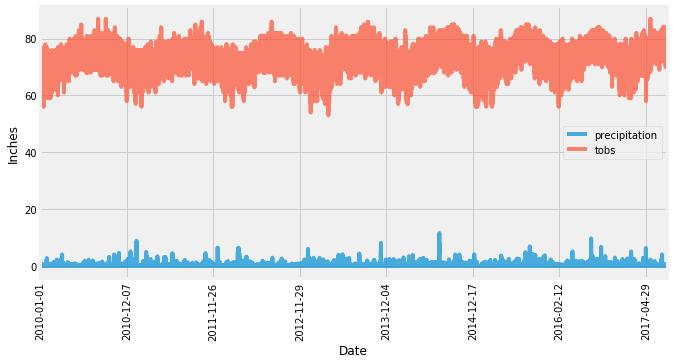

<Figure size 432x288 with 0 Axes>

In [48]:
# Perform a query to retrieve the data and precipitation scores
result= session.query(Measurement).\
        filter((Measurement.prcp)!=None)

# Save the query results as a Pandas DataFrame and set the index to the date column
res= pd.read_sql_query(result.statement, session.bind)
res.set_index('date', inplace= True)

# Sort the dataframe by date
res.sort_values('date', inplace= True)

# Use Pandas Plotting with Matplotlib to plot the data
res= res.rename(columns={'prcp': 'precipitation'})
ax= res[['precipitation', 'tobs']].plot(figsize=(10,5), rot=90, alpha=0.7)
ax.set_ylabel('Inches')
ax.set_xlabel('Date')
plt.show()
plt.tight_layout()

In [49]:
# Use Pandas to calcualte the summary statistics for the precipitation data
print(res['precipitation'].describe())

count    18103.000000
mean         0.160644
std          0.468746
min          0.000000
25%          0.000000
50%          0.010000
75%          0.110000
max         11.530000
Name: precipitation, dtype: float64


In [215]:
# Design a query to show how many stations are available in this dataset?
Total_stations_unique= session.query(Measurement.station).distinct().count()
print(f'There are {Total_stations_unique} unique stations available in this dataset')

There are 9 unique stations available in this dataset


In [384]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

sta_freq= session.query(func.count(Measurement.station).\
          label('Nos'),Measurement.station).group_by(Measurement.station).\
          order_by(desc('Nos'))
sorted_stations=[]
for station in sta_freq:
    sorted_stations.append(list(np.ravel(station))[1])
sorted_stations

['USC00519281',
 'USC00519397',
 'USC00513117',
 'USC00519523',
 'USC00516128',
 'USC00514830',
 'USC00511918',
 'USC00517948',
 'USC00518838']

In [67]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temp= session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
          filter(Measurement.station=='USC00519281')
for min_temp, max_temp, avg_temp in temp:
    print(f'min_temp is {min_temp},\nhigh_temp is {max_temp},\navg_temp is {avg_temp}')


min_temp is 54.0,
high_temp is 85.0,
avg_temp is 71.66378066378067


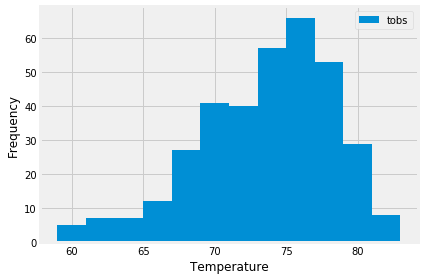

In [68]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
records= session.query(Measurement.date, Measurement.tobs).\
        filter(and_(Measurement.date>='2016-08-23'), (Measurement.station=='USC00519281')).\
        group_by(Measurement.date)
df_records= pd.read_sql_query(records.statement, session.bind)
df_records.sort_values('date', inplace=True)
df_records.set_index('date', inplace= True)

plt.hist(df_records['tobs'], bins=12, label=['tobs'])
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

## Bonus Challenge Assignment

In [75]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(list(np.ravel(calc_temps('2012-02-28', '2012-03-05'))))

[62.0, 69.57142857142857, 74.0]


In [242]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date= '2017-02-14'
end_date= '2017-02-28'
a= list(np.ravel(calc_temps(start_date, end_date)))
print(a)

[61.0, 70.8695652173913, 79.0]


<Figure size 72x144 with 0 Axes>

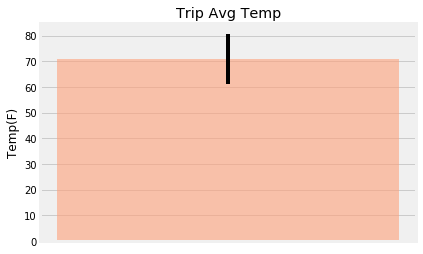

<Figure size 72x144 with 0 Axes>

In [280]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr=a[1]-a[0]
plt.bar(a[1], a[1], color='lightsalmon', alpha= 0.6)
plt.errorbar(a[1],a[1], yerr, color='black')
plt.ylabel('Temp(F)')
plt.title('Trip Avg Temp')
plt.xticks([])
plt.figure(figsize=(1,2))

In [309]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sec= [func.sum(Measurement.prcp), Measurement.station,Station.name, Station.latitude,
                   Station.longitude, Station.elevation]
info= session.query(*sec).\
    filter(and_(Measurement.date >= start_date, Measurement.date <= end_date, Measurement.station==Station.station)).\
    group_by(Measurement.station).order_by(desc((func.sum(Measurement.prcp))))

for item in info:
    print(list(np.ravel(item)))

['1.4', 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', '21.3331', '-157.8025', '152.4']
['1.06', 'USC00519281', 'WAIHEE 837.5, HI US', '21.45167', '-157.84888999999998', '32.9']
['1.02', 'USC00513117', 'KANEOHE 838.1, HI US', '21.4234', '-157.8015', '14.6']
['0.87', 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', '21.33556', '-157.71139', '19.5']
['0.83', 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', '21.5213', '-157.8374', '7.0']
['0.23', 'USC00519397', 'WAIKIKI 717.2, HI US', '21.2716', '-157.8168', '3.0']
['0.17', 'USC00517948', 'PEARL CITY, HI US', '21.3934', '-157.9751', '11.9']


In [308]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [344]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
base_start= dt.date(2017,2,14)
base_end= dt.date(2017,2,28)

# Use the start and end date to create a range of dates
date_list=[base_end - dt.timedelta(x) for x in range(14)][::-1]

# Stip off the year and save a list of %m-%d strings
datestr=[]
for date in date_list:
    s= date.strftime("%m-%d")
    datestr.append(s)
# Loop through the list of %m-%d strings and calculate the normals for each date
normals=[]
for item in datestr:
    nor= daily_normals(item)
    normals.append(nor)
normals    

[[(56.0, 70.28813559322033, 79.0)],
 [(59.0, 70.48214285714286, 76.0)],
 [(62.0, 70.47272727272727, 77.0)],
 [(63.0, 70.79629629629629, 77.0)],
 [(60.0, 69.33962264150944, 77.0)],
 [(63.0, 70.14035087719299, 76.0)],
 [(63.0, 69.79629629629629, 76.0)],
 [(60.0, 70.15789473684211, 83.0)],
 [(62.0, 70.35593220338983, 81.0)],
 [(61.0, 68.56666666666666, 76.0)],
 [(61.0, 68.59649122807018, 76.0)],
 [(62.0, 69.89285714285714, 78.0)],
 [(58.0, 69.98148148148148, 77.0)],
 [(65.0, 70.65517241379311, 80.0)]]

In [375]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
# Reformat the datestr list to include year in its format
datestr1=[]
for date in date_list:
    s= date.strftime("%Y-%m-%d")
    datestr1.append(s)

normals_list= []    
for item in normals:
    s= list(np.ravel(item))
    normals_list.append(s)
p= pd.DataFrame([lis for lis in normals_list], index= datestr1, columns= ['tmin', 'tmax', 'tavg'])
p

,tmin,tmax,tavg
2017-02-15,56.0,70.288136,79.0
2017-02-16,59.0,70.482143,76.0
2017-02-17,62.0,70.472727,77.0
2017-02-18,63.0,70.796296,77.0
2017-02-19,60.0,69.339623,77.0
2017-02-20,63.0,70.140351,76.0
2017-02-21,63.0,69.796296,76.0
2017-02-22,60.0,70.157895,83.0
2017-02-23,62.0,70.355932,81.0
2017-02-24,61.0,68.566667,76.0


Text(0.5, 0, 'Date')

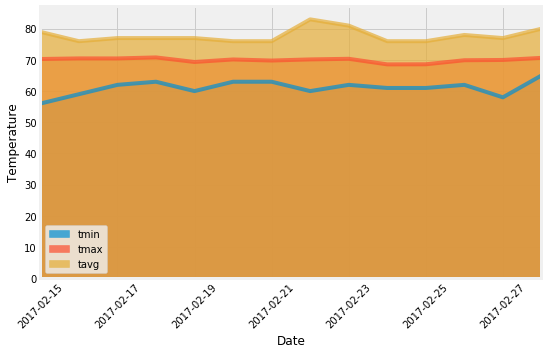

In [381]:
# Plot the daily normals as an area plot with `stacked=False`
ax= p.plot.area(figsize=(8,5), rot=45, alpha=0.7 ,stacked=False)
ax.set_ylabel('Temperature')
ax.set_xlabel('Date')